In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from datetime import datetime


In [81]:
import pandas as pd
customers = pd.read_csv('../datasets/Customers.csv')
products = pd.read_csv('../datasets/Products.csv')
transactions = pd.read_csv('../datasets/Transactions.csv')

customers.head()  # To see customer data
products.head()   # To see product data
transactions.head()  # To see transaction data


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [103]:
# Merge transactions with customer data
data = transactions.merge(customers, on='CustomerID', how='left')

# Merge the result with product data
data = data.merge(products, on='ProductID', how='left')


In [111]:
# Convert 'TransactionDate' to datetime format
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

# Calculate Recency (days since last purchase)
recency = data.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['Recency'] = (pd.to_datetime('today') - recency['TransactionDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

# Calculate Frequency (number of transactions per customer)
frequency = data.groupby('CustomerID').size().reset_index(name='Frequency')

# Calculate Monetary (total spending per customer)
monetary = data.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary = monetary.rename(columns={'TotalValue': 'Monetary'})

# Merge the features into a single dataframe
customer_data = recency.merge(frequency, on='CustomerID')
customer_data = customer_data.merge(monetary, on='CustomerID')

# Now, customer_data has Recency, Frequency, and Monetary columns


In [112]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['Recency', 'Frequency', 'Monetary']])


In [113]:
from sklearn.cluster import KMeans

# Apply K-Means clustering (you can choose the number of clusters, here it's set to 5)
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)


In [136]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(customer_data_scaled, customer_data['Cluster'])
print(f"DB Index: {db_index}")


DB Index: 1.163181233784265


In [137]:
from sklearn.cluster import KMeans

# Assuming you've already prepared the RFM data and are performing clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Set the number of clusters (change as needed)
rfm['Cluster'] = kmeans.fit_predict(rfm[['Recency', 'Frequency', 'Monetary']])

# Now you can check the 'Cluster' column
print(rfm.head())

  CustomerID  Recency  Frequency  Monetary        CustomerName RecencyScore  \
0      C0001       55          5   3354.52    Lawrence Carroll            2   
1      C0002       25          4   1862.74      Elizabeth Lutz            3   
2      C0003      125          4   2725.38      Michael Rivera            1   
3      C0004        4          8   5354.88  Kathleen Rodriguez            3   
4      C0005       54          3   2034.24         Laura Weber            2   

  FrequencyScore MonetaryScore  RFM_Score       Segment  Cluster  
0              2             2          6  Medium Value        1  
1              1             1          5  Medium Value        1  
2              1             2          4  Medium Value        1  
3              3             3          9    High Value        0  
4              1             1          4  Medium Value        1  


In [138]:
# Get the mean values for each cluster
cluster_centroids = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_centroids)


            Recency  Frequency     Monetary
Cluster                                    
0         47.352941   7.205882  5789.797353
1         62.379747   4.468354  2648.524937
2        136.848485   2.272727   969.088182
3         74.434783   5.760870  4264.329348
4         32.285714   8.857143  7967.131429


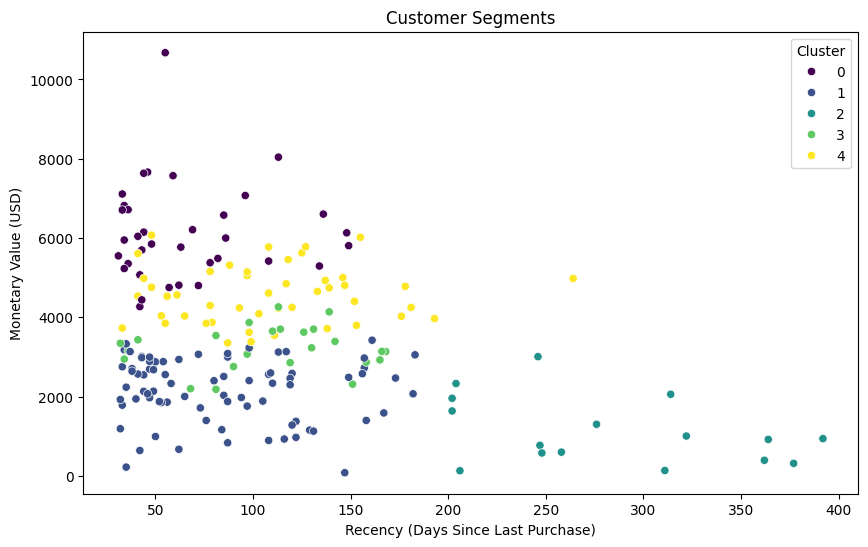

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_data['Recency'], y=customer_data['Monetary'], hue=customer_data['Cluster'], palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Recency (Days Since Last Purchase)')
plt.ylabel('Monetary Value (USD)')
plt.legend(title='Cluster')
plt.show()


In [140]:
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(customer_data_scaled, customer_data['Cluster'])
print(f"Silhouette Score: {silhouette}")


Silhouette Score: 0.29144318629993804


In [141]:
# Analyze average Recency, Frequency, and Monetary for each cluster
cluster_profile = customer_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(cluster_profile)


   Cluster     Recency  Frequency     Monetary
0        0   66.171429   8.257143  6133.808857
1        1   84.307692   3.641026  2171.428077
2        2  283.187500   1.812500  1132.325000
3        3  107.916667   6.625000  3228.568750
4        4  107.760870   5.195652  4572.565435
